In [138]:
import numpy as np
import sys
import numpy
numpy.set_printoptions(threshold=sys.maxsize)


#bring in dipoles and energies
dipoles = np.load("LiH_r_1.4_6311g_fci_Dipoles_200.npy")
energies = np.load("LiH_r_1.4_6311g_fci_Energies_200.npy")
omega = 0.12086 

#dipoles = np.load("BH3_631g_fci_Dipoles.npy")
#energies = np.load("BH3_631g_fci_Energies.npy")
#omega  = 0.48989211893480444


print(energies.shape)

#lambda vectors 
A_vec = np.array([0.0, 0.0, 0.05])

def calc_A0(A_vec):
    return np.sqrt(1/(2 * omega))  * A_vec
A0 = calc_A0(A_vec)


m_n = 0 #num_photons


mu_n = 0 #electronic state


n_elec = 200



(200,)


In [139]:

def build_d_matrix(A_vec, dipoles):
    #d_matrix =  np.einsum('k, ijk -> ij', lambda_vec, dipoles[:mu_n, : mu_n, :])
    #d_matrix =  np.einsum('k, ijk -> ij', lambda_vec, dipoles)
    #d_matrix =  np.tensordot(dipoles, lambda_vec, axes = 1)

    A0 = calc_A0(A_vec)

    d_matrix =  np.einsum('k, ijk -> ij', A0, dipoles[:n_elec, : n_elec, :])

    #for when the matrix is only upper triangular
    d_matrix = d_matrix + d_matrix.T - np.diag(np.diag(d_matrix))

    return d_matrix

def build_d_matrix_2(A_vec, dipoles, n_el):
        A0 = calc_A0(A_vec)
        _d = np.zeros((n_el, n_el))
        for a in range(n_el):
            for b in range(n_el):
                _d[a, b] = np.dot(A0, dipoles[a, b, :])

        return _d




d_matrix = build_d_matrix(A_vec, dipoles)
#d_matrix = build_d_matrix_2(lambda_vec, dipoles, n_elec)



print(d_matrix[0:4, 0:4])


def calc_first_order_energy_correction(d_matrix, omega, mu_n, neglect_dipole_self_energy = False):

    E_n_1 = 0
    for gamma in range(0, len(energies)):
        E_n_1 += d_matrix[mu_n][gamma]*d_matrix[gamma][mu_n]

    E_n_1 = omega* E_n_1 

    if neglect_dipole_self_energy:
        return 0
    else:
        return E_n_1                




def delta(i,j):
    if i ==j:
        return 1
    else:
        return 0

#unsimplified version of second order energy correction to check if the same answer is gotten
def calc_second_order_energy_correction_unsimplified(d_matrix, omega, mu_n, energies, m_n):
    E_n_2 = 0


    for mu_l in range(0, len(energies)):

            #for m_l in range(max(m_n-1,0), m_n+2):
            for m_l in range(max(0, m_n-1), m_n+2 ):

                if(mu_l == mu_n and m_l == m_n):
                    pass
                else:

                    sum_over_energy_states_gamma = 0
                    for gamma in range(0, len(energies)):
                        #numerator += d_matrix[gamma][mu_l]*d_matrix[mu_l][gamma]
                        sum_over_energy_states_gamma += (d_matrix[mu_l][gamma]*d_matrix[gamma][mu_n] * delta(m_l, m_n))

                    
                    E_n_2 += (((-omega * d_matrix[mu_l][mu_n] * (np.sqrt(m_n +1) * delta(m_l, m_n + 1)  + np.sqrt(m_n) * delta(m_l, m_n-1)) ) + (omega * sum_over_energy_states_gamma))**2   )/ (energies[mu_n] + (m_n * omega) - energies[mu_l] - (m_l * omega))

                    #print((((-omega * d_matrix[mu_l][mu_n] * (np.sqrt(m_n +1) * delta(m_l, m_n +1)  + np.sqrt(m_n) * delta(m_l, m_n-1)) ) + (omega * sum_over_energy_states_gamma))**2   )/ (energies[mu_n] + (m_n * omega) - energies[mu_l] - (m_l * omega)))


    return E_n_2




def calc_second_order_energy_correction(d_matrix, omega, mu_n, energies, m_n, neglect_dipole_self_energy=False):
    E_n_2 = 0


    for mu_l in range(0, len(energies)):
            for m_l in range(max(m_n-1,0), m_n+2):
                if(mu_l == mu_n and m_l == m_n):
                    pass
                else:

                    if m_l == m_n + 1:
                        E_n_2 +=  ( (d_matrix[mu_l][mu_n] * np.sqrt(m_n+1)) ** 2 )/(energies[mu_n] - energies[mu_l] - omega)

                        #print( d_matrix[mu_l][mu_n]  )


                    elif m_l  == m_n - 1:
                        E_n_2 +=  ( (d_matrix[mu_l][mu_n] * np.sqrt(m_n)) ** 2 )/(energies[mu_n] - energies[mu_l] + omega)

                        #print(( (d_matrix[mu_l][mu_n] * np.sqrt(m_n+1)) ** 2 )/(energies[mu_n] - energies[mu_l] - omega))

        
                    elif m_l  == m_n and neglect_dipole_self_energy == False:

                        
                        numerator = 0
                        for gamma in range(0, len(energies)):
                            numerator += d_matrix[mu_l][gamma]*d_matrix[gamma][mu_n]

                            #print("numerator: ", numerator)


                            #print("d_matrix[mu_l][gamma]: ",  d_matrix[mu_l][gamma] ," d_matrix[gamma][mu_n]: ", d_matrix[gamma][mu_n])
                

                        E_n_2 += (numerator**2) / ((energies[mu_n] - energies[mu_l]))

                        #print("denominator:" , ((energies[mu_n] - energies[mu_l])))

                        #print("contrib: ",(numerator**2) / ((energies[mu_n] - energies[mu_l])) )



    E_n_2 = E_n_2 * omega**2
    return E_n_2



def calc_energy_correction_to_first_order(mu_n, E_n_1):
    return energies[mu_n] + (omega * m_n) + E_n_1 

def calc_energy_correction_to_second_order(mu_n, E_n_1, E_n_2):
    return energies[mu_n] + (omega * m_n) + E_n_1 + E_n_2 



E_n_1 = calc_first_order_energy_correction(d_matrix, omega, mu_n)


E_n_2 = calc_second_order_energy_correction(d_matrix, omega, mu_n, energies, m_n=m_n)



print("E_n_1: ", E_n_1)
print("E-n_2: ", E_n_2)


print("uncorrected_energy:" , energies[mu_n]+(omega * m_n))

print("energy corrected to second order: " , calc_energy_correction_to_second_order(mu_n, E_n_1, E_n_2))

qed_fci_energies = np.load("LiH_r_1.4_6311g_qedfci_Energies.npy")
print("qed_fci_energy:", qed_fci_energies[mu_n])

[[-3.47308789e-01 -4.14871937e-15  9.15916885e-02  3.49717749e-15]
 [-4.14871937e-15  4.49810696e-02  2.55309930e-15  2.13381025e-15]
 [ 9.15916885e-02  2.55309930e-15  7.78522187e-02  9.47145340e-15]
 [ 3.49717749e-15  2.13381025e-15  9.47145340e-15 -1.25402994e-01]]
E_n_1:  0.018223863385475852
E-n_2:  -0.01641545254463344
uncorrected_energy: -8.012194758182286
energy corrected to second order:  -8.010386347341443
qed_fci_energy: -8.00913664849758


[[-3.47308789e-01 -4.14871937e-15  9.15916885e-02  3.49717749e-15]
 [-4.14871937e-15  4.49810696e-02  2.55309930e-15  2.13381025e-15]
 [ 9.15916885e-02  2.55309930e-15  7.78522187e-02  9.47145340e-15]
 [ 3.49717749e-15  2.13381025e-15  9.47145340e-15 -1.25402994e-01]]
LiH full ci energy value:  -8.012194758182286
lambda vector:  [0.    0.    0.025]
energy to second order:  -8.01160346330927
lambda vector:  [0.    0.    0.024]
energy to second order:  -8.011646468456451
lambda vector:  [0.    0.    0.023]
energy to second order:  -8.011688254214736
lambda vector:  [0.    0.    0.022]
energy to second order:  -8.011728753593724
lambda vector:  [0.    0.    0.021]
energy to second order:  -8.01176790245366
lambda vector:  [0.   0.   0.02]
energy to second order:  -8.01180563950545
lambda vector:  [0.    0.    0.019]
energy to second order:  -8.011841906310663
lambda vector:  [0.    0.    0.018]
energy to second order:  -8.011876647281511
lambda vector:  [0.    0.    0.017]
energy to secon

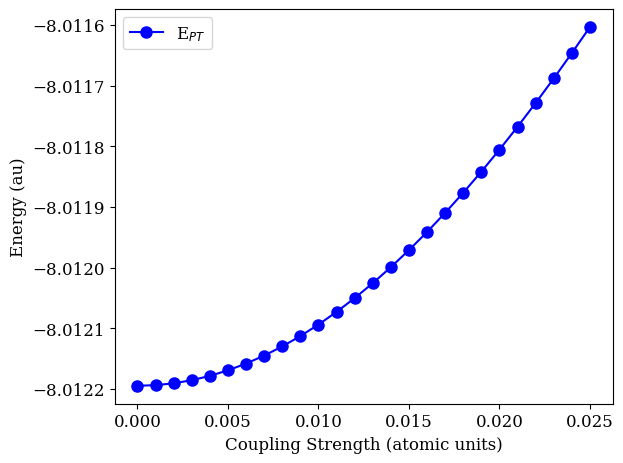

In [144]:

lambda_vecs = []
energy_vals = [] 

d_matrix = build_d_matrix(A_vec, dipoles)


#coherent state transformation
A_vec = np.array([0.0, 0.0, 0.05])


print(d_matrix[0:4, 0:4])
print("LiH full ci energy value: ",energies[0])

A_vec = np.array([0.0, 0.0, 0.025])
for i in range(0, 26):

    d_matrix = build_d_matrix(A_vec, dipoles)
    #d_matrix = coherent_state_d_matrix(d_matrix)
    

    print("lambda vector: ", A_vec)
    E_n_1 = calc_first_order_energy_correction(d_matrix, omega, mu_n)


    E_n_2 = calc_second_order_energy_correction(d_matrix, omega, mu_n, energies, m_n=m_n)


    print("energy to second order: " , calc_energy_correction_to_second_order(mu_n, E_n_1, E_n_2))


    lambda_vecs.append(A_vec[2])
    energy_vals.append(calc_energy_correction_to_second_order(mu_n, E_n_1, E_n_2))
    A_vec[2] += -0.001

print(energy_vals)

energy_vals.reverse()
lambda_vecs.reverse()

from matplotlib import pyplot as plt
from matplotlib import cm
from matplotlib import rcParams
rcParams['font.family'] = 'serif'
rcParams['font.size'] = 12
plt.plot(lambda_vecs, energy_vals, color="blue",  marker="o", ms="8", label="E$_{PT}$")
plt.xlabel("Coupling Strength (atomic units)")
plt.ylabel("Energy (au)")
#plt.xticks([0, 0.005, 0.01, 0.015, 0.020, 0.025])
#plt.xlim(0, 0.025)
#plt.ylim( -8.0122, -8.01204)
plt.tight_layout()
plt.legend()
plt.savefig("perturbation_theory_compare_coupling_strengths.png", dpi=150)


(200, 200, 3)
[[ 3.53108650e-03  8.29743874e-17 -1.83183377e-03 -6.99435498e-17]
 [ 8.29743874e-17 -4.31471068e-03 -5.10619860e-17 -4.26762050e-17]
 [-1.83183377e-03 -5.10619860e-17 -4.97213366e-03 -1.89429068e-16]
 [-6.99435498e-17 -4.26762050e-17 -1.89429068e-16 -9.07029414e-04]]
LiH full ci energy value:  -8.012194758182286
lambda vector:  [0.    0.    0.025]
energy to second order:  -8.013410240631528
lambda vector:  [0.    0.    0.024]
energy to second order:  -8.013314946807506
lambda vector:  [0.    0.    0.023]
energy to second order:  -8.013223542527323
lambda vector:  [0.    0.    0.022]
energy to second order:  -8.013136027790978
lambda vector:  [0.    0.    0.021]
energy to second order:  -8.01305240259847
lambda vector:  [0.   0.   0.02]
energy to second order:  -8.0129726669498
lambda vector:  [0.    0.    0.019]
energy to second order:  -8.012896820844967
lambda vector:  [0.    0.    0.018]
energy to second order:  -8.012824864283973
lambda vector:  [0.    0.    0.017]
e

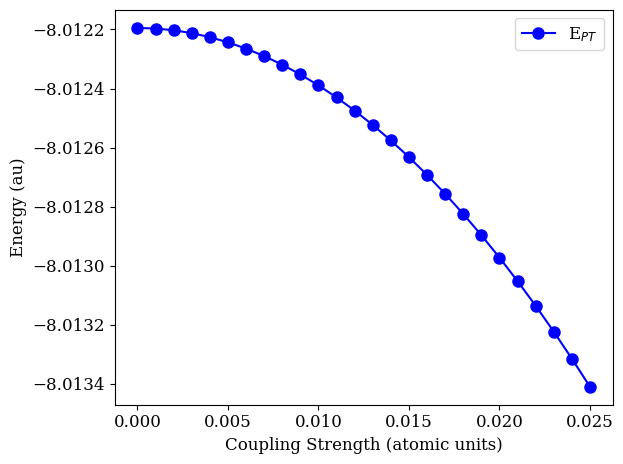

In [141]:
#coherent state transformation
lambda_vecs = []
energy_vals = [] 
print(dipoles.shape)


def coherent_state_d_matrix(dipoles, A_vec):
    d_expectation_value = np.dot(dipoles[0,0,:], A_vec)
    d_matrix = build_d_matrix(A_vec, dipoles)
    d_matrix = d_matrix - np.dot(d_expectation_value, np.eye(n_elec, n_elec))
    #d_matrix = np.subtract(d_matrix , np.dot( d_expectation_value, np.ones((n_elec, n_elec))))

    return d_matrix

d_matrix = coherent_state_d_matrix(dipoles, A_vec)

print(d_matrix[0:4, 0:4])
print("LiH full ci energy value: ",energies[0])

A_vec = np.array([0.0, 0.0, .025])
for i in range(0, 26):

    d_matrix = build_d_matrix(A_vec, dipoles)
    d_matrix = coherent_state_d_matrix(dipoles, A_vec)
    

    print("lambda vector: ", A_vec)
    E_n_1 = calc_first_order_energy_correction(d_matrix, omega, mu_n, neglect_dipole_self_energy=True)


    E_n_2 = calc_second_order_energy_correction(d_matrix, omega, mu_n, energies, m_n=m_n, neglect_dipole_self_energy=True)


    print("energy to second order: " , calc_energy_correction_to_second_order(mu_n, E_n_1, E_n_2))


    lambda_vecs.append(A_vec[2])
    energy_vals.append(calc_energy_correction_to_second_order(mu_n, E_n_1, E_n_2))
    A_vec[2] += -0.001

print(energy_vals)

energy_vals.reverse()
lambda_vecs.reverse()

from matplotlib import pyplot as plt
from matplotlib import cm
from matplotlib import rcParams
rcParams['font.family'] = 'serif'
rcParams['font.size'] = 12
plt.plot(lambda_vecs, energy_vals, color="blue",  marker="o", ms="8", label="E$_{PT}$")
plt.xlabel("Coupling Strength (atomic units)")
plt.ylabel("Energy (au)")
#plt.xticks([0, 0.005, 0.01, 0.015, 0.020, 0.025])
#plt.xlim(0, 0.025)
#plt.ylim( -8.0122, -8.01204)
plt.tight_layout()
plt.legend()
plt.savefig("perturbation_theory_compare_coupling_strengths.png", dpi=150)

In [142]:
"""
print("LiH full ci energy value: ",energies[0])

total_corrections = []

lambda_vec = np.array([0.0, 0.0, 0.05])

for i in reversed(range(2, 50)):

    n_elec = i
    energies = energies[0:n_elec]

    d_matrix = build_d_matrix(lambda_vec, dipoles)

    E_n_1 = calc_first_order_energy_correction(d_matrix, omega, mu_n)

    E_n_2 = calc_second_order_energy_correction(d_matrix, omega, mu_n, energies, m_n=m_n)

    print(E_n_1)
    print(E_n_2)

    print("energy corrected to first order: " , calc_energy_correction_to_first_order(mu_n, E_n_1))
    print("energy to second order: " , calc_energy_correction_to_second_order(mu_n, E_n_1, E_n_2))


    total_corrections.append(E_n_1+E_n_2)

import matplotlib.pyplot as plt


total_corrections.reverse()
#plt.plot(range(2,50), np.e ** np.array(total_corrections))
plt.plot(range(2,50),np.array(total_corrections))

plt.show()
plt.close()



E_n_2 = calc_second_order_energy_correction(d_matrix, omega, mu_n, energies, m_n=m_n)

print(qed_fci_energies[0] - energies)
"""

'\nprint("LiH full ci energy value: ",energies[0])\n\ntotal_corrections = []\n\nlambda_vec = np.array([0.0, 0.0, 0.05])\n\nfor i in reversed(range(2, 50)):\n\n    n_elec = i\n    energies = energies[0:n_elec]\n\n    d_matrix = build_d_matrix(lambda_vec, dipoles)\n\n    E_n_1 = calc_first_order_energy_correction(d_matrix, omega, mu_n)\n\n    E_n_2 = calc_second_order_energy_correction(d_matrix, omega, mu_n, energies, m_n=m_n)\n\n    print(E_n_1)\n    print(E_n_2)\n\n    print("energy corrected to first order: " , calc_energy_correction_to_first_order(mu_n, E_n_1))\n    print("energy to second order: " , calc_energy_correction_to_second_order(mu_n, E_n_1, E_n_2))\n\n\n    total_corrections.append(E_n_1+E_n_2)\n\nimport matplotlib.pyplot as plt\n\n\ntotal_corrections.reverse()\n#plt.plot(range(2,50), np.e ** np.array(total_corrections))\nplt.plot(range(2,50),np.array(total_corrections))\n\nplt.show()\nplt.close()\n\n\n\nE_n_2 = calc_second_order_energy_correction(d_matrix, omega, mu_n, en

In [143]:
A_vec = np.array([0.0, 0.0, 0.05])

#photon number basis
d_matrix = build_d_matrix(A_vec, dipoles)


E_n_1 = calc_first_order_energy_correction(d_matrix, omega, mu_n)


E_n_2 = calc_second_order_energy_correction(d_matrix, omega, mu_n, energies, m_n=m_n)


print("E_n_1: ", E_n_1)
print("E-n_2: ", E_n_2)


print("uncorrected_energy:" , energies[mu_n]+(omega * m_n))

print("energy corrected to second: " , calc_energy_correction_to_second_order(mu_n, E_n_1, E_n_2))






#coherent state transformation
d_matrix = build_d_matrix(A_vec, dipoles)


d_matrix = coherent_state_d_matrix(dipoles, A_vec)
E_n_1 = calc_first_order_energy_correction(d_matrix, omega, mu_n)


E_n_2 = calc_second_order_energy_correction(d_matrix, omega, mu_n, energies, m_n=m_n)


print("E_n_1 for coherent state: ", E_n_1)
print("E-n_2 for coherent state: ", E_n_2)


print("uncorrected_energy:" , energies[mu_n]+(omega * m_n))

print("energy corrected to second order for coherent state: " , calc_energy_correction_to_second_order(mu_n, E_n_1, E_n_2))

qed_fci_energies = np.load("LiH_r_1.4_6311g_qedfci_Energies.npy")
print("qed_fci_energy:", qed_fci_energies[mu_n])

E_n_1:  0.018223863385475852
E-n_2:  -0.01641545254463344
uncorrected_energy: -8.012194758182286
energy corrected to second:  -8.010386347341443
E_n_1 for coherent state:  0.007412698839445967
E-n_2 for coherent state:  -0.005080269480431231
uncorrected_energy: -8.012194758182286
energy corrected to second order for coherent state:  -8.00986232882327
qed_fci_energy: -8.00913664849758
